In [1]:
# todo: export the model from train.ipynb

# todo: copy import from train.ipynb
# todo: copy normalize() from train.ipynb
# todo: copy predict() from train.ipynb

# todo: inject saved model into predict()
# todo: turn predict() into a GreatAI service

# todo: log prediction into output trace

In [2]:
from great_ai.utilities import clean
from great_ai import use_model, GreatAI, log_metric, ClassificationOutput
import re

def normalize(text: str) -> str:
    cleaned = clean(text, convert_to_ascii=True).lower()
    return re.sub(r"[^a-z]+", " ", cleaned)

@GreatAI.create
@use_model('financial-sentiment')
def predict_financial_sentiment(text: str, model) -> ClassificationOutput:
    """Classify news articles into Negative, Neutral, or Positive classes using a linear SVM."""
    text = normalize(text)
    features = model.named_steps["tfidfvectorizer"].transform([text])
    prediction = model.named_steps["sgdclassifier"].predict(features)[0]

    explanation = [
        (feature_name, weight)
        for weight, feature_name in sorted(
            (
                (feature_weight * feature, feature_name)
                for feature_name, feature_weight, feature in zip(
                    model.named_steps["tfidfvectorizer"].get_feature_names_out(),
                    model.named_steps["sgdclassifier"].coef_[list(model.named_steps["sgdclassifier"].classes_).index(prediction)],
                    features.toarray()[0],
                )
                if feature * feature_weight != 0
            ),
            reverse=True,
        )
    ][:10]

    log_metric('prediction', prediction, disable_logging=True)

    return prediction, explanation

Environment variable ENVIRONMENT is not set, defaulting to development mode ‼️
Cannot find credentials files, defaulting to using ParallelTinyDbDriver
The selected tracing database (ParallelTinyDbDriver) is not recommended for production
Cannot find credentials files, defaulting to using LargeFileLocal
GreatAI (v0.1.10): configured ✅
  🔩 tracing_database: ParallelTinyDbDriver
  🔩 large_file_implementation: LargeFileLocal
  🔩 is_production: False
  🔩 should_log_exception_stack: True
  🔩 prediction_cache_size: 512
  🔩 dashboard_table_size: 50
You still need to check whether you follow all best practices before trusting your deployment.
> Find out more at https://se-ml.github.io/practices
Fetching cached versions of financial-sentiment
Latest version of financial-sentiment is 1 (from versions: 0, 1)
File financial-sentiment-1 found in cache


100%|██████████| 200/200 [00:24<00:00,  8.03it/s]


              precision    recall  f1-score   support

    negative       0.45      0.17      0.25        29
     neutral       0.70      0.85      0.77       102
    positive       0.77      0.72      0.75        69

    accuracy                           0.71       200
   macro avg       0.64      0.58      0.59       200
weighted avg       0.69      0.71      0.69       200



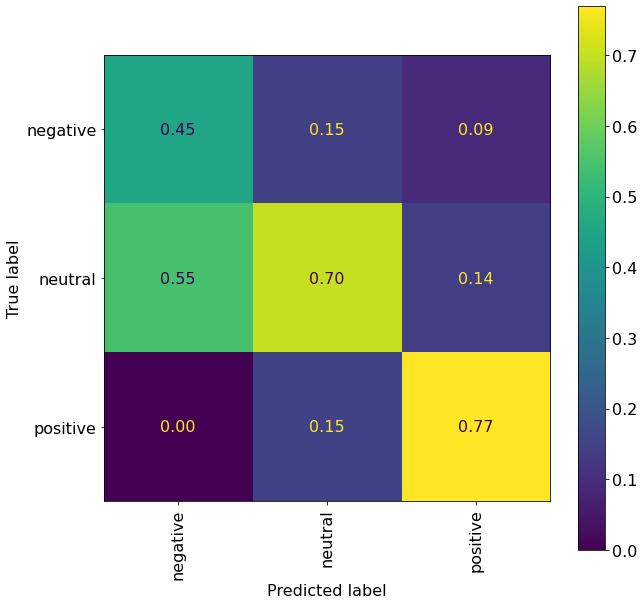

In [3]:
# todo: add integration test (copy metric derivation from train.ipynb)

if __name__ == '__main__':
    from great_ai import query_ground_truth
    import matplotlib.pyplot as plt
    from sklearn import metrics

    test_split = query_ground_truth('test', return_max_count=200)

    traces = predict_financial_sentiment.process_batch([t.input for t in test_split])
    y_predicted = [t.output[0] for t in traces]
    y_test = [t.output for t in test_split]

    %matplotlib inline
    plt.rcParams["figure.figsize"] = (10, 10)
    plt.rcParams["font.size"] = 16

    print(metrics.classification_report(y_test, y_predicted))
    metrics.ConfusionMatrixDisplay.from_predictions(
        y_true=y_test,
        y_pred=y_predicted,
        xticks_rotation="vertical",
        normalize="pred",
        values_format=".2f",
    )

In [4]:
# todo: serve prediction model
# todo: open dashboard

!great-ai deploy_done.ipynb

2022-08-11 11:14:04 |     INFO | Converting notebook to Python script
2022-08-11 11:14:04 |     INFO | Found `predict_financial_sentiment` to be the GreatAI app 
2022-08-11 11:14:04 |     INFO | Uvicorn running on http://0.0.0.0:6060 (Press CTRL+C to quit)
2022-08-11 11:14:06 |  WARNING | Environment variable ENVIRONMENT is not set, defaulting to development mode ‼️
2022-08-11 11:14:06 |  WARNING | Cannot find credentials files, defaulting to using ParallelTinyDbDriver
2022-08-11 11:14:06 |  WARNING | The selected tracing database (ParallelTinyDbDriver) is not recommended for production
2022-08-11 11:14:06 |  WARNING | Cannot find credentials files, defaulting to using LargeFileLocal
2022-08-11 11:14:06 |     INFO | GreatAI (v0.1.10): configured ✅
2022-08-11 11:14:06 |     INFO |   🔩 tracing_database: ParallelTinyDbDriver
2022-08-11 11:14:06 |     INFO |   🔩 large_file_implementation: LargeFileLocal
2022-08-11 11:14:06 |     INFO |   🔩 is_production: False
2022-08-11 11:14:06 |     INF